In [1]:
%%capture
!git lfs install
!git clone https://huggingface.co/Cene655/dalle2_decoder
!gdown https://drive.google.com/uc?id=1-3eGsUa7P5jSsM5R2Gu-OF_scW8YJ42e

In [2]:
%%capture
!pip install git+https://github.com/NeuralPushkin/Dalle2-Decoder.git
!pip install git+https://github.com/openai/CLIP.git
!pip install git+https://github.com/openai/glide-text2im.git

In [3]:
from PIL import Image
from IPython.display import display
import torch as th
from dalle2_decoder.model_creation import create_model_and_diffusion as create_model_and_diffusion_dalle2
from dalle2_decoder.model_creation import model_and_diffusion_defaults as model_and_diffusion_defaults_dalle2
import clip
from glide_text2im.model_creation import (
    create_model_and_diffusion,
    model_and_diffusion_defaults_upsampler
)
from glide_text2im.download import load_checkpoint

has_cuda = th.cuda.is_available()
device = th.device('cpu' if not has_cuda else 'cuda')

In [4]:
options = model_and_diffusion_defaults_dalle2()
options['use_fp16'] = False
options['diffusion_steps'] = 200

model, diffusion = create_model_and_diffusion_dalle2(**options)
model.eval()
#if has_cuda:
#    model.convert_to_fp16()
model.to(device)
model.load_state_dict(th.load('/content/dalle2_decoder/dalle2_decoder.pt'))
print('total base parameters', sum(x.numel() for x in model.parameters()))

total base parameters 385621318


In [5]:
options_up = model_and_diffusion_defaults_upsampler()
options_up['use_fp16'] = has_cuda
options_up['timestep_respacing'] = '50' # use 27 diffusion steps for very fast sampling
model_up, diffusion_up = create_model_and_diffusion(**options_up)
model_up.eval()
if has_cuda:
    model_up.convert_to_fp16()
model_up.to(device)
model_up.load_state_dict(load_checkpoint('upsample', device))
print('total upsampler parameters', sum(x.numel() for x in model_up.parameters()))

  0%|          | 0.00/1.59G [00:00<?, ?iB/s]

total upsampler parameters 398361286


In [6]:
clip_model, clip_preprocess = clip.load("ViT-L/14", device=device)

100%|███████████████████████████████████████| 890M/890M [00:15<00:00, 61.1MiB/s]


In [7]:
def model_fn(x_t, ts, **kwargs):
    guidance_scale = 3
    half = x_t[: len(x_t) // 2]
    combined = th.cat([half, half], dim=0)
    model_out = model(combined, ts, **kwargs)
    eps, rest = model_out[:, :3], model_out[:, 3:]
    cond_eps, uncond_eps = th.split(eps, len(eps) // 2, dim=0)
    half_eps = uncond_eps + guidance_scale * (cond_eps - uncond_eps)
    eps = th.cat([half_eps, half_eps], dim=0)
    return th.cat([eps, rest], dim=1)

In [8]:
def show_images(batch: th.Tensor):
    """ Display a batch of images inline. """
    scaled = ((batch + 1)*127.5).round().clamp(0,255).to(th.uint8).cpu()
    reshaped = scaled.permute(2, 0, 3, 1).reshape([batch.shape[2], -1, 3])
    display(Image.fromarray(reshaped.numpy()))

In [9]:
prompt = 'city'
image_path = '/content/image.jpg'

In [10]:
out_dict = {}
image = clip_preprocess(Image.open(image_path)).unsqueeze(0).to(device)
with th.no_grad():
    image_features = clip_model.encode_image(image).float()
    text_features = clip_model.encode_text(clip.tokenize([prompt]).to(device))
tokens = model.tokenizer.encode(prompt)
tokens, mask = model.tokenizer.padded_tokens_and_mask(
    tokens, options['text_ctx']
)

# Create the classifier-free guidance tokens (empty)
full_batch_size = 2
uncond_tokens, uncond_mask = model.tokenizer.padded_tokens_and_mask(
    [], options['text_ctx']
)
#out_dict["clip_emb"] = th.tensor([[0] * 768] + [[0] * 768] * 1)#th.tensor(list(image_features.cpu().numpy()) + [[0] * 768] * 1)
out_dict["clip_emb"] = th.tensor(list(image_features.cpu().numpy()) + [[0] * 768] * 1)

out_dict["tokens"] = th.tensor([tokens] * 1 + [uncond_tokens] * 1, device=device)
out_dict["mask"] = th.tensor([mask] * 1 + [uncond_mask] * 1, dtype=th.bool, device=device, )

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:210.)


In [15]:
sample = diffusion.p_sample_loop(
        model_fn,
        (2, 3, 64, 64),
        clip_denoised=True,
        model_kwargs=out_dict,
        device='cuda'
        )[:1]

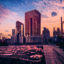

In [16]:
show_images(sample)

In [17]:
tokens = model_up.tokenizer.encode(prompt)
tokens, mask = model_up.tokenizer.padded_tokens_and_mask(
    tokens, options_up['text_ctx']
)

# Create the model conditioning dict.
model_kwargs = dict(
    # Low-res image to upsample.
    low_res=((sample+1)*127.5).round()/127.5 - 1,

    # Text tokens
    tokens=th.tensor(
        [tokens] * 1, device=device
    ),
    mask=th.tensor(
        [mask] * 1,
        dtype=th.bool,
        device=device,
    ),
)

# Sample from the base model.
model_up.del_cache()
up_shape = (1, 3, options_up["image_size"], options_up["image_size"])
up_samples = diffusion_up.ddim_sample_loop(
    model_up,
    up_shape,
    noise=th.randn(up_shape, device=device) * 0.997,
    device=device,
    clip_denoised=True,
    progress=True,
    model_kwargs=model_kwargs,
    cond_fn=None,
)[:1]
model_up.del_cache()

  0%|          | 0/50 [00:00<?, ?it/s]

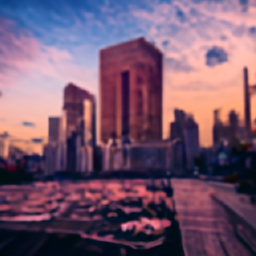

In [18]:
show_images(up_samples)